# Compose: Training a model to generate music

In [18]:
import os
import pickle
import numpy
import pydot
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network, prepare_sequences_with_velocity, create_network_with_velocity

## Set parameters

In [36]:
# run params
section = 'compose'
run_id = '0006'
genre_name = 'jazz'
composer_name='ChetBaker'

run_folder = 'run/{}/{}/'.format(section, genre_name)
run_folder += '_'.join([run_id, composer_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', genre_name, composer_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

## Extract the notes

In [37]:
data_folder

'data/jazz/ChetBaker'

In [53]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []
    velocities = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)
            velocities.extend([0]* seq_len)

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                        velocities.append(element.volume.velocity)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)
                        velocities.append(element.volume.velocity)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)
                    velocities.append(element.volume.velocity)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
    with open(os.path.join(store_folder, 'velocities'), 'wb') as f:
        pickle.dump(velocities, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 
    with open(os.path.join(store_folder, 'velocities'), 'wb') as f:
        pickle.dump(velocities, f) 

5 files in total
1 Parsing data/jazz/ChetBaker/ChetBaker_ThereWillNeverBeAnotherYou-1_FINAL.mid
2 Parsing data/jazz/ChetBaker/ChetBaker_IFallInLoveTooEasily_FINAL.mid
3 Parsing data/jazz/ChetBaker/ChetBaker_LongAgoAndFarAway_FINAL.mid
4 Parsing data/jazz/ChetBaker/ChetBaker_JustFriends_FINAL.mid
5 Parsing data/jazz/ChetBaker/ChetBaker_ThereWillNeverBeAnotherYou-2_FINAL.mid


## Create the lookup tables

In [39]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
velocity_names, n_velocities = get_distinct(velocities)
distincts = [note_names, n_notes, duration_names, n_durations, velocity_names, n_velocities]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
velocity_to_int, int_to_velocity = create_lookups(velocity_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration, velocity_to_int, int_to_velocity]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [40]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A3': 0,
 'A3.E-4': 1,
 'A4': 2,
 'A4.B-4': 3,
 'B-3': 4,
 'B-3.E-4': 5,
 'B-4': 6,
 'B-4.C5': 7,
 'B-4.D5': 8,
 'B3': 9,
 'B3.C#4': 10,
 'B3.E-4': 11,
 'B4': 12,
 'B4.C5': 13,
 'B4.D5': 14,
 'B4.E-5': 15,
 'C#4': 16,
 'C#4.D4': 17,
 'C#5': 18,
 'C4': 19,
 'C4.A4': 20,
 'C4.C#4': 21,
 'C4.D4': 22,
 'C4.E-4': 23,
 'C4.F#4': 24,
 'C5': 25,
 'C5.C#5': 26,
 'C5.D5': 27,
 'D4': 28,
 'D4.E-4': 29,
 'D4.E4': 30,
 'D5': 31,
 'D5.E-5': 32,
 'D5.E5': 33,
 'D5.F5': 34,
 'E-4': 35,
 'E-4.E4': 36,
 'E-4.F4': 37,
 'E-4.G4': 38,
 'E-5': 39,
 'E-5.F5': 40,
 'E4': 41,
 'E4.F#4': 42,
 'E4.F4': 43,
 'E5': 44,
 'E5.F#5': 45,
 'E5.F5': 46,
 'F#4': 47,
 'F#4.A4': 48,
 'F#4.E-5': 49,
 'F#4.G4': 50,
 'F#5': 51,
 'F#5.G5': 52,
 'F4': 53,
 'F4.G4': 54,
 'F5': 55,
 'F5.F#5': 56,
 'F5.G5': 57,
 'G#4': 58,
 'G#4.A4': 59,
 'G#4.B4': 60,
 'G#5': 61,
 'G3': 62,
 'G3.A3': 63,
 'G4': 64,
 'G4.A4': 65,
 'G4.B-4': 66,
 'G4.B4': 67,
 'G4.G#4': 68,
 'G5': 69,
 'G5.G#5': 70,
 'START': 71}

In [41]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(7, 12): 7,
 Fraction(2, 3): 8,
 0.75: 9,
 Fraction(5, 6): 10,
 Fraction(11, 12): 11,
 1.0: 12,
 Fraction(13, 12): 13,
 Fraction(7, 6): 14,
 1.25: 15,
 Fraction(4, 3): 16,
 1.5: 17,
 Fraction(5, 3): 18,
 2.0: 19,
 2.25: 20,
 Fraction(7, 3): 21,
 2.5: 22,
 Fraction(8, 3): 23,
 5.5: 24}

In [42]:
print('\nvelocity_to_int')
velocity_to_int


velocity_to_int


{0: 0,
 10: 1,
 61: 2,
 71: 3,
 72: 4,
 74: 5,
 76: 6,
 77: 7,
 78: 8,
 79: 9,
 80: 10,
 81: 11,
 82: 12,
 83: 13,
 84: 14,
 85: 15,
 86: 16,
 87: 17,
 88: 18,
 89: 19,
 90: 20,
 91: 21,
 92: 22,
 93: 23,
 94: 24,
 95: 25,
 96: 26,
 97: 27,
 98: 28,
 99: 29,
 100: 30,
 101: 31,
 102: 32,
 103: 33,
 104: 34,
 105: 35,
 106: 36,
 107: 37,
 108: 38,
 109: 39,
 110: 40,
 111: 41,
 112: 42,
 113: 43,
 114: 44,
 115: 45,
 116: 46,
 117: 47,
 118: 48,
 119: 49,
 120: 50,
 121: 51,
 122: 52,
 123: 53,
 124: 54,
 125: 55,
 126: 56,
 127: 57}

In [43]:
len(notes)

1025

In [44]:
velocity_names, n_velocities = get_distinct(velocities)

In [45]:
velocity_names[0]

0

## Prepare the sequences used by the Neural Network

In [46]:
network_input, network_output = prepare_sequences_with_velocity(notes, durations, velocities, lookups, distincts, seq_len)

In [47]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('velocity input')
print(network_input[2][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])
print('velocity output')
print(network_output[2][0])

pitch input
[71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71
 71 71 71 71 71 71 71 71]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
velocity input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
duration output
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
velocity output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Create the structure of the neural network

In [48]:
model, att_model = create_network_with_velocity(n_notes, n_durations, n_velocities, embed_size, rnn_units, use_attention)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 100)    7200        input_7[0][0]                    
____________________________________________________________________________________________

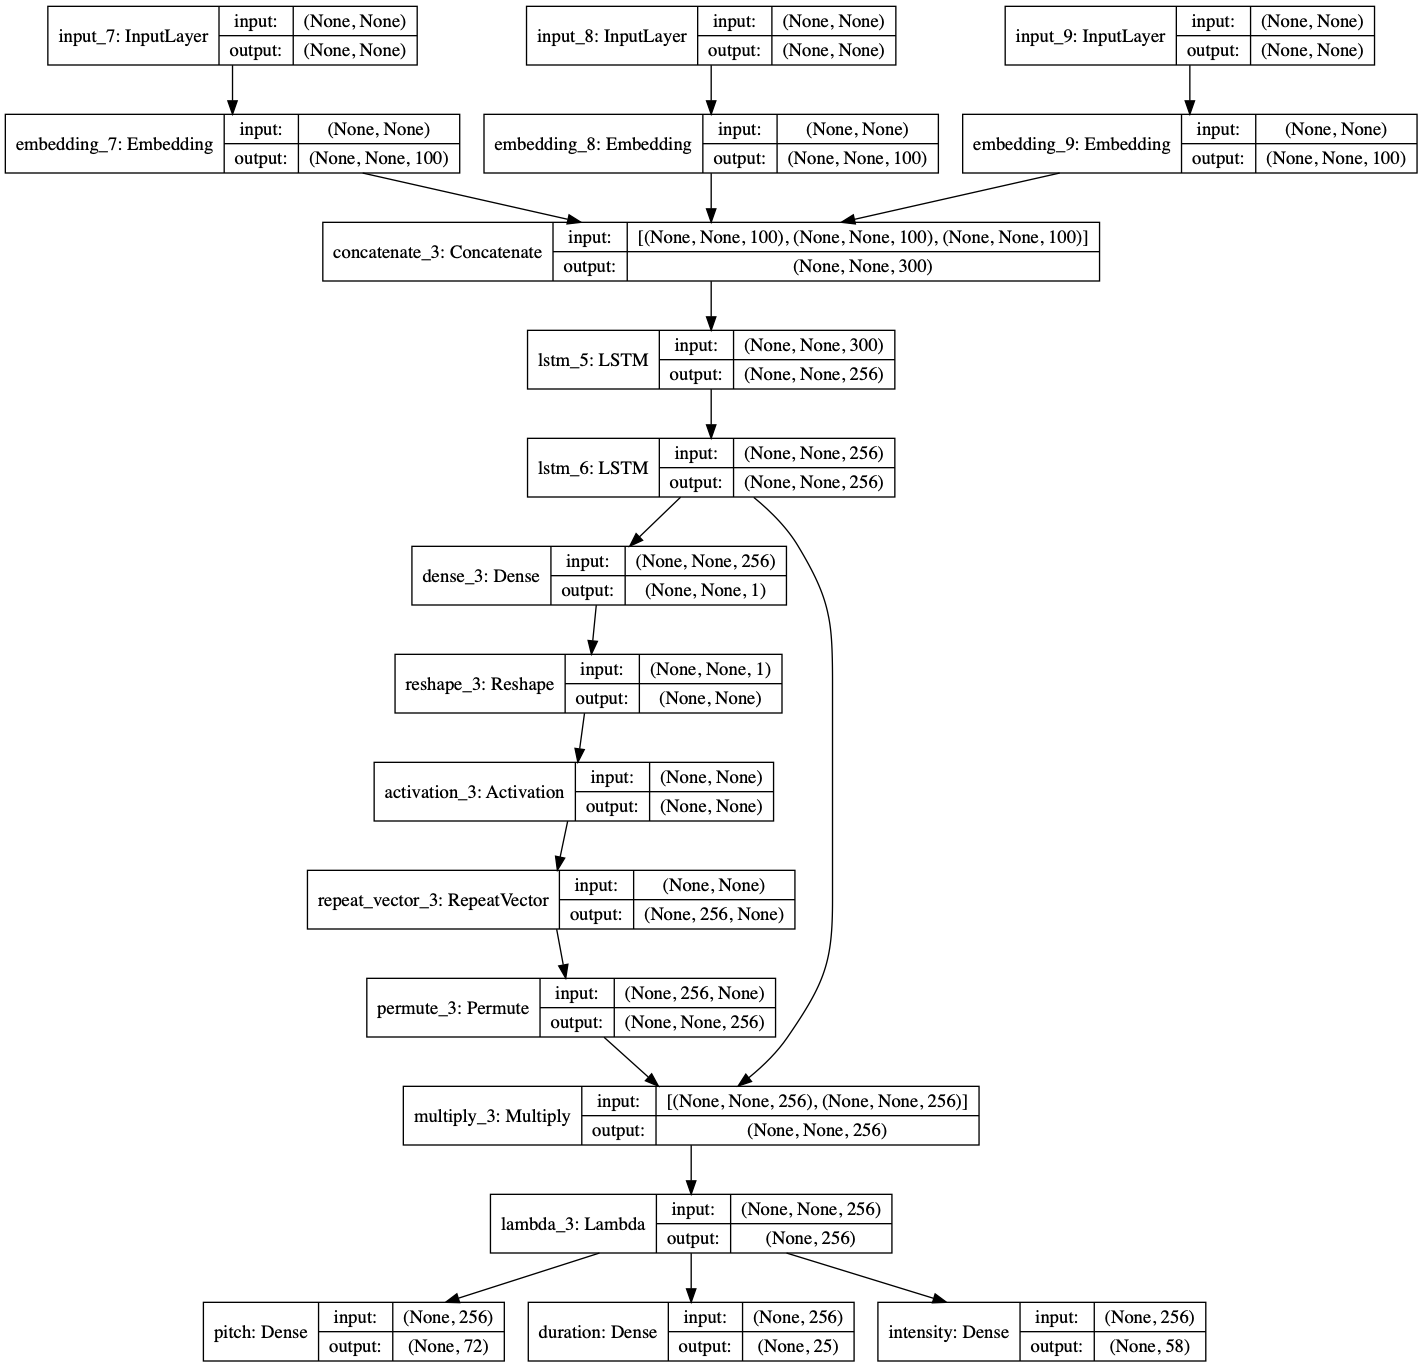

In [49]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [50]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [51]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
model.fit(network_input, network_output
          , epochs=2000000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )



/Users/weiliang/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 794 samples, validate on 199 samples
Epoch 1/2000000
794/794 [==============================] - 8s 10ms/step - loss: 9.8414 - pitch_loss: 3.4987 - duration_loss: 2.5043 - intensity_loss: 3.8333 - val_loss: 8.8862 - val_pitch_loss: 3.1443 - val_duration_loss: 2.1830 - val_intensity_loss: 3.6812
Epoch 2/2000000
794/794 [==============================] - 8s 10ms/step - loss: 9.1693 - pitch_loss: 3.2222 - duration_loss: 2.2859 - intensity_loss: 3.6462 - val_loss: 9.0829 - val_pitch_loss: 3.1869 - val_duration_loss: 2.2442 - val_intensity_loss: 3.6966
Epoch 3/2000000
794/794 [==============================] - 8s 10ms/step - loss: 8.8006 - pitch_loss: 3.1147 - duration_loss: 2.1679 - intensity_loss: 3.5197 - val_loss: 9.0230 - val_pitch_loss: 3.1716 - val_duration_loss: 2.2049 - val_intensity_loss: 3.6815
Epoch 4/2000000
794/794 [==============================] - 9s 11ms/step - loss: 8.5152 - pitch_loss: 3.0275 - duration_loss: 2.0470 - intensity_loss: 3.4399 - val_loss: 9.0960 - va

794/794 [==============================] - 11s 13ms/step - loss: 5.0256 - pitch_loss: 1.6435 - duration_loss: 1.2823 - intensity_loss: 2.1015 - val_loss: 13.4907 - val_pitch_loss: 5.0955 - val_duration_loss: 3.0633 - val_intensity_loss: 5.1165
Epoch 33/2000000
794/794 [==============================] - 9s 12ms/step - loss: 4.8676 - pitch_loss: 1.5904 - duration_loss: 1.2533 - intensity_loss: 2.0180 - val_loss: 13.6572 - val_pitch_loss: 5.1853 - val_duration_loss: 3.0566 - val_intensity_loss: 5.1622
Epoch 34/2000000
794/794 [==============================] - 11s 14ms/step - loss: 4.7969 - pitch_loss: 1.5633 - duration_loss: 1.2315 - intensity_loss: 2.0017 - val_loss: 13.1996 - val_pitch_loss: 5.0159 - val_duration_loss: 2.9372 - val_intensity_loss: 5.0342
Epoch 35/2000000
794/794 [==============================] - 8s 10ms/step - loss: 4.6379 - pitch_loss: 1.5243 - duration_loss: 1.1841 - intensity_loss: 1.9260 - val_loss: 14.0042 - val_pitch_loss: 5.3901 - val_duration_loss: 3.0931 - va

794/794 [==============================] - 8s 11ms/step - loss: 1.8191 - pitch_loss: 0.6240 - duration_loss: 0.4545 - intensity_loss: 0.7365 - val_loss: 17.5380 - val_pitch_loss: 6.4994 - val_duration_loss: 4.2608 - val_intensity_loss: 6.4253
Epoch 64/2000000
794/794 [==============================] - 9s 11ms/step - loss: 1.6950 - pitch_loss: 0.5843 - duration_loss: 0.4359 - intensity_loss: 0.6743 - val_loss: 17.7315 - val_pitch_loss: 6.4622 - val_duration_loss: 4.2396 - val_intensity_loss: 6.5260
Epoch 65/2000000
794/794 [==============================] - 8s 10ms/step - loss: 1.7832 - pitch_loss: 0.6140 - duration_loss: 0.4552 - intensity_loss: 0.7128 - val_loss: 18.0634 - val_pitch_loss: 6.7204 - val_duration_loss: 4.3156 - val_intensity_loss: 6.5642
Epoch 66/2000000
794/794 [==============================] - 8s 11ms/step - loss: 1.5811 - pitch_loss: 0.5434 - duration_loss: 0.4066 - intensity_loss: 0.6296 - val_loss: 17.9366 - val_pitch_loss: 6.5320 - val_duration_loss: 4.3315 - val_

794/794 [==============================] - 8s 11ms/step - loss: 1.0091 - pitch_loss: 0.3462 - duration_loss: 0.2613 - intensity_loss: 0.4018 - val_loss: 20.2887 - val_pitch_loss: 7.4381 - val_duration_loss: 5.1425 - val_intensity_loss: 7.3448
Epoch 95/2000000
794/794 [==============================] - 6s 8ms/step - loss: 0.9465 - pitch_loss: 0.3345 - duration_loss: 0.2499 - intensity_loss: 0.3680 - val_loss: 19.6576 - val_pitch_loss: 7.0654 - val_duration_loss: 5.2132 - val_intensity_loss: 7.1354
Epoch 96/2000000
794/794 [==============================] - 6s 7ms/step - loss: 0.8761 - pitch_loss: 0.3031 - duration_loss: 0.2207 - intensity_loss: 0.3519 - val_loss: 20.4355 - val_pitch_loss: 7.3782 - val_duration_loss: 5.3271 - val_intensity_loss: 7.3618
Epoch 97/2000000
794/794 [==============================] - 9s 11ms/step - loss: 1.0118 - pitch_loss: 0.3614 - duration_loss: 0.2477 - intensity_loss: 0.4013 - val_loss: 20.3990 - val_pitch_loss: 7.3993 - val_duration_loss: 5.3195 - val_in

794/794 [==============================] - 8s 11ms/step - loss: 0.7109 - pitch_loss: 0.2426 - duration_loss: 0.1892 - intensity_loss: 0.2755 - val_loss: 21.1279 - val_pitch_loss: 7.6973 - val_duration_loss: 5.6794 - val_intensity_loss: 7.5285
Epoch 126/2000000
794/794 [==============================] - 10s 13ms/step - loss: 0.7255 - pitch_loss: 0.2473 - duration_loss: 0.1947 - intensity_loss: 0.2815 - val_loss: 21.2832 - val_pitch_loss: 7.6580 - val_duration_loss: 5.7445 - val_intensity_loss: 7.6197
Epoch 127/2000000
794/794 [==============================] - 11s 13ms/step - loss: 0.6642 - pitch_loss: 0.2417 - duration_loss: 0.1752 - intensity_loss: 0.2502 - val_loss: 21.0397 - val_pitch_loss: 7.5727 - val_duration_loss: 5.6085 - val_intensity_loss: 7.4626
Epoch 128/2000000
794/794 [==============================] - 9s 12ms/step - loss: 0.7201 - pitch_loss: 0.2442 - duration_loss: 0.1963 - intensity_loss: 0.2774 - val_loss: 21.9563 - val_pitch_loss: 7.8424 - val_duration_loss: 5.7859 -

794/794 [==============================] - 6s 8ms/step - loss: 0.6111 - pitch_loss: 0.2091 - duration_loss: 0.1663 - intensity_loss: 0.2342 - val_loss: 21.9923 - val_pitch_loss: 7.8234 - val_duration_loss: 6.0504 - val_intensity_loss: 7.9101
Epoch 157/2000000
794/794 [==============================] - 9s 11ms/step - loss: 0.5358 - pitch_loss: 0.1924 - duration_loss: 0.1408 - intensity_loss: 0.2022 - val_loss: 22.0949 - val_pitch_loss: 7.9470 - val_duration_loss: 6.0643 - val_intensity_loss: 7.7607
Epoch 158/2000000
794/794 [==============================] - 7s 9ms/step - loss: 0.6561 - pitch_loss: 0.2268 - duration_loss: 0.1692 - intensity_loss: 0.2571 - val_loss: 22.7017 - val_pitch_loss: 7.9690 - val_duration_loss: 6.1743 - val_intensity_loss: 8.2272
Epoch 159/2000000
794/794 [==============================] - 11s 14ms/step - loss: 0.6388 - pitch_loss: 0.2351 - duration_loss: 0.1637 - intensity_loss: 0.2409 - val_loss: 22.0657 - val_pitch_loss: 7.7589 - val_duration_loss: 6.0067 - va